In [10]:
import testing
import rejson
import redis
import numpy as np
import datetime
import json
from scipy.stats import describe
from matplotlib import pyplot as plt
client = rejson.Client(host='localhost', port=6379, decode_responses=True)
redisclient = redis.Redis(host='localhost', port=6379, decode_responses=True)


In [11]:
# Actions

normalset = lambda data: client.set("normalset", data)
redisset = lambda data: redisclient.set("normalset", data)
jsonset = lambda data, path: client.jsonset('jsonset', path, data)

normalget = lambda: client.get("normalset")
redisget = lambda: redisclient.set("normalset")
jsonget = lambda path: client.jsonset('jsonset', path)

In [16]:
def bury_data(data, levels=10):
    if levels == 1:
        return {"data": data}
    else:
        return {"data": bury_data(data, levels-1), "fake": 1}
    
def set_testing():
    sizes = [10 ** i for i in range(7)]
    for s in sizes:
        data = testing.generate_data(format='string', strlen=s)
        start = datetime.datetime.now()
        _ = json.dumps({'data':data})
        print("Time to Create JSON {}: {}".format(len(data), (datetime.datetime.now() - start).total_seconds() * 1000))
        
        # Set the data in using set method inside rejson
        redisset_datapoints = np.array(
            testing.multitrial_time_test(
                func=redisset, 
                kwargs={'data':data},
                iterations=100
            )
        )

        # Set the data in using set method inside rejson
        set_datapoints = np.array(
            testing.multitrial_time_test(
                func=normalset, 
                kwargs={'data':data},
                iterations=100
            )
        )

        # Set the data using json starting at the root
        json_one_deep_root_set = np.array(
            testing.multitrial_time_test(
                func=jsonset, 
                kwargs={'data':{'data': data}, 'path':rejson.Path.rootPath()},
                iterations=100
            )
        )

        # Set the data using json at the level it is supposed to be 
        json_one_deep_direct_set = np.array(
            testing.multitrial_time_test(
                func=jsonset, 
                kwargs={'data':data, 'path':rejson.Path('.data')},
                iterations=100
            )
        )
        
        # Set the 10 level json data using json starting at the root
        json_ten_deep_root_set = np.array(
            testing.multitrial_time_test(
                func=jsonset, 
                kwargs={'data':bury_data(data, levels=10), 'path':rejson.Path.rootPath()},
                iterations=100
            )
        )

        # Set the 10 level json data json at the level it is supposed to be
        json_ten_deep_direct_set = np.array(
            testing.multitrial_time_test(
                func=jsonset, 
                kwargs={'data':bury_data(data, levels=10), 'path':rejson.Path("".join([".data" for i in range(10)]))},
                iterations=100
            )
        )
        
        fig, ax = plt.subplots(1, 6, figsize=(20, 5), sharey = True)
        ax[0].boxplot(redisset_datapoints)
        ax[0].set_xlabel("Redis's Set: {:0.2} ".format(np.mean(np.array(redisset_datapoints))))
        ax[0].set_ylabel("Milliseconds")
        
        ax[1].boxplot(set_datapoints)
        ax[1].set_xlabel("ReJson's Set: {:0.2} ".format(np.mean(np.array(set_datapoints))))
        
        ax[2].boxplot(json_one_deep_root_set)
        ax[2].set_xlabel("One Level Root Set: {:0.2} ".format(np.mean(np.array(json_one_deep_root_set))))
        
        ax[3].boxplot(json_one_deep_direct_set)
        ax[3].set_xlabel("One Level Direct Set: {:0.2} ".format(np.mean(np.array(json_one_deep_direct_set))))
        
        ax[4].boxplot(json_ten_deep_root_set)
        ax[4].set_xlabel("Ten Level Root Set: {:0.2} ".format(np.mean(np.array(json_ten_deep_root_set))))
        
        ax[5].boxplot(json_ten_deep_direct_set)
        ax[5].set_xlabel("Ten Level Direct Set: {:0.2} ".format(np.mean(np.array(json_ten_deep_direct_set))))
        
        fig.suptitle("Message Size = {:.2e} length string".format(s))
        fig.show()
        
        
# def get_testing():
#     sizes = [10 ** i for i in range(7)]
#     for s in sizes:
#         # Read the data in using set method inside rejson
#         redisget_datapoints = np.array(
#             testing.multitrial_time_test(
#                 func=redisget, 
#                 kwargs={},
#                 iterations=100
#             )
#         )

#         # Set the data in using set method inside rejson
#         get_datapoints = np.array(
#             testing.multitrial_time_test(
#                 func=normalget, 
#                 kwargs={},
#                 iterations=100
#             )
#         )

#         # Set the data using json starting at the root
#         json_one_deep_root_get = np.array(
#             testing.multitrial_time_test(
#                 func=jsonget, 
#                 kwargs={'path':rejson.Path.rootPath()},
#                 iterations=100
#             )
#         )

#         # Set the data using json at the level it is supposed to be 
#         json_one_deep_direct_get = np.array(
#             testing.multitrial_time_test(
#                 func=jsonget, 
#                 kwargs={'path':rejson.Path('.data')},
#                 iterations=100
#             )
#         )
        
#         # Set the 10 level json data using json starting at the root
#         json_ten_deep_root_get = np.array(
#             testing.multitrial_time_test(
#                 func=jsonget, 
#                 kwargs={'path':rejson.Path.rootPath()},
#                 iterations=100
#             )
#         )

#         # Set the 10 level json data json at the level it is supposed to be
#         json_ten_deep_direct_get = np.array(
#             testing.multitrial_time_test(
#                 func=jsonget, 
#                 kwargs={'path':rejson.Path("".join([".data" for i in range(10)]))},
#                 iterations=100
#             )
#         )
        
#         fig, ax = plt.subplots(1, 6, figsize=(20, 5), sharey = True)
#         ax[0].boxplot(redisget_datapoints)
#         ax[0].set_xlabel("Redis's Get: {:0.2} ".format(np.mean(np.array(redisget_datapoints))))
#         ax[0].set_ylabel("Milliseconds")
        
#         ax[1].boxplot(get_datapoints)
#         ax[1].set_xlabel("ReJson's Get: {:0.2} ".format(np.mean(np.array(get_datapoints))))
        
#         ax[2].boxplot(json_one_deep_root_get)
#         ax[2].set_xlabel("One Level Root Get: {:0.2} ".format(np.mean(np.array(json_one_deep_root_get))))
        
#         ax[3].boxplot(json_one_deep_direct_get)
#         ax[3].set_xlabel("One Level Direct Get: {:0.2} ".format(np.mean(np.array(json_one_deep_direct_get))))
        
#         ax[4].boxplot(json_ten_deep_root_get)
#         ax[4].set_xlabel("Ten Level Root Get: {:0.2} ".format(np.mean(np.array(json_ten_deep_root_get))))
        
#         ax[5].boxplot(json_ten_deep_direct_get)
#         ax[5].set_xlabel("Ten Level Direct Get: {:0.2} ".format(np.mean(np.array(json_ten_deep_direct_get))))
        
#         fig.suptitle("Message Size = {:.2e} length string".format(s))
#         fig.show()

                                                              

Time to Create JSON 27: 0.015000000000000001
Time to Create JSON 27: 0.019
Time to Create JSON 100: 0.02
Time to Create JSON 1000: 0.022
Time to Create JSON 10000: 0.051
Time to Create JSON 100000: 0.364
Time to Create JSON 1000000: 3.215


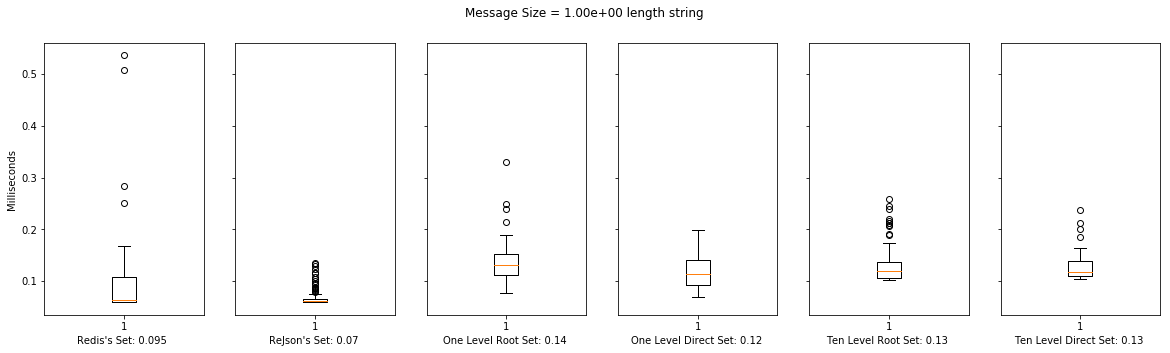

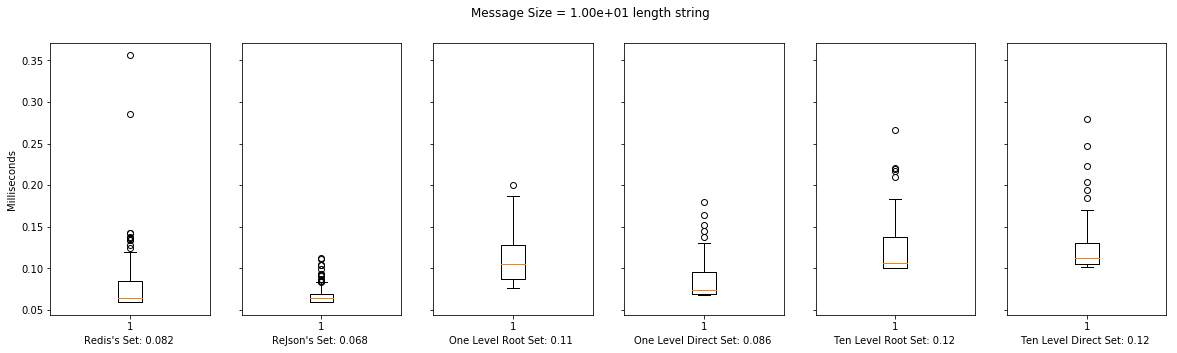

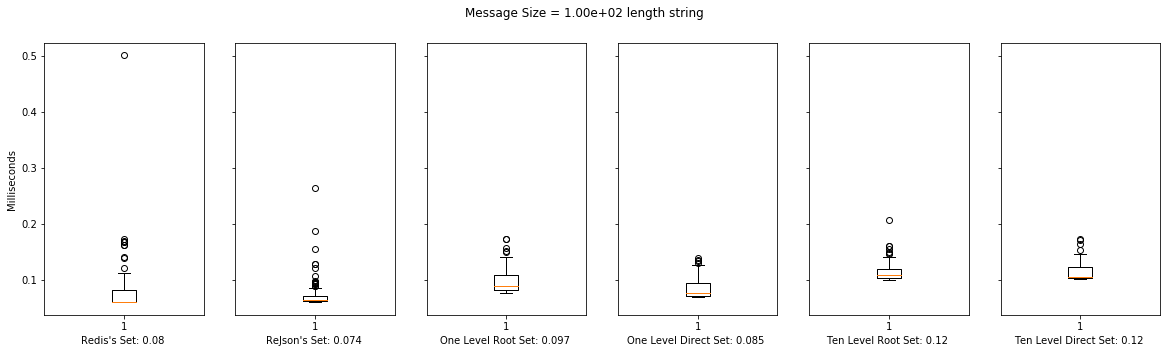

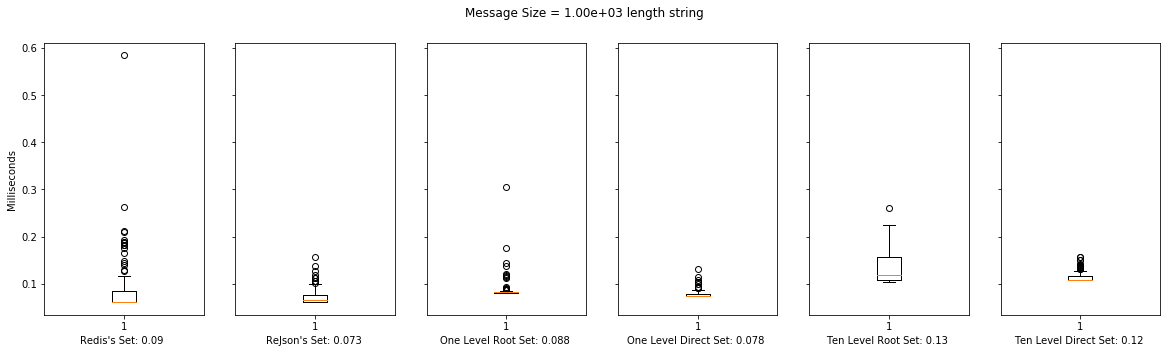

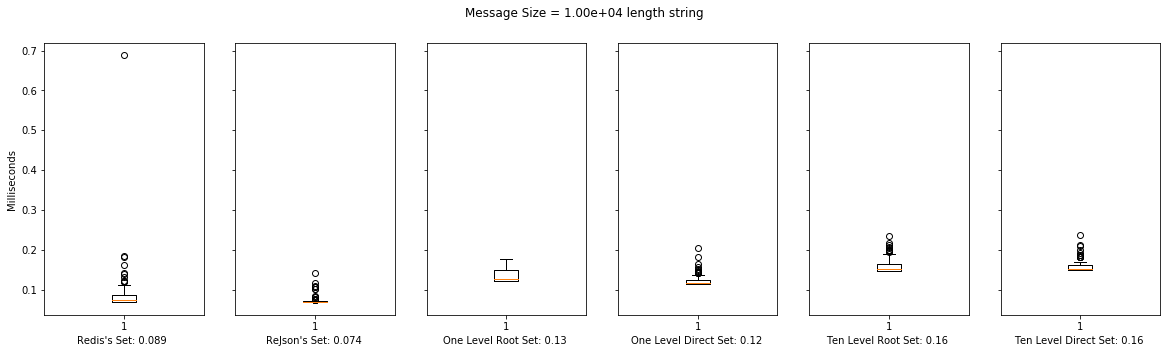

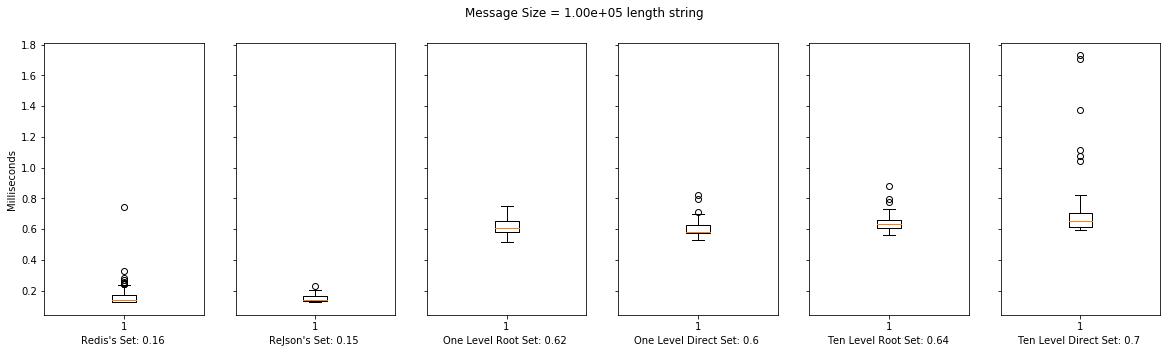

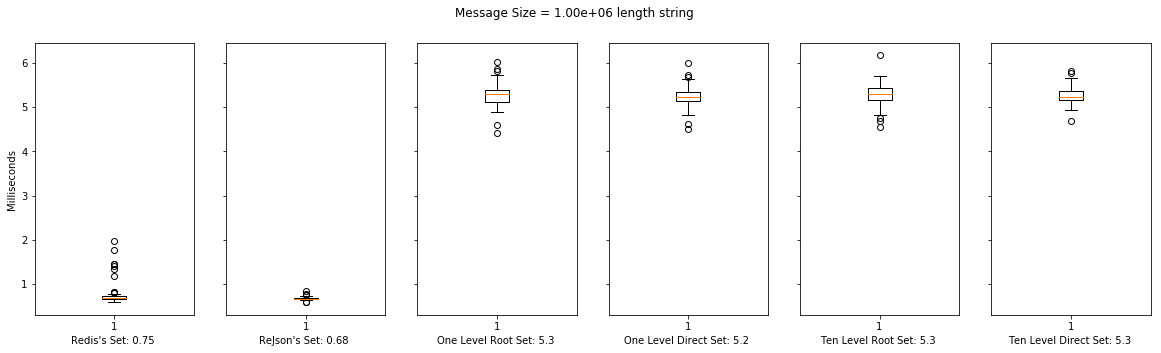

In [17]:
set_testing()